# Cameroon Legal Chatbot: **Colab Training Notebook**

Welcome! This project builds a **domain-specific T5 chatbot** to answer questions about Cameroonian law. You'll see how modern NLP is applied—from dataset to deployment, with a focus on professional clarity and best practices.

---

## **Table of Contents**

1. [Project Introduction](#introduction)
2. [Environment Setup](#setup)
3. [NLTK Download & Seeding](#nltk)
4. [Data Upload & Exploration](#data)
5. [Visualization & Preprocessing](#viz)
6. [Train/Val/Test Split](#split)
7. [T5 Input Formatting](#t5)
8. [Tokenization Function](#tokenize)
9. [Custom PyTorch Dataset](#dataset)
10. [Model Training, BLEU Evaluation & Saving](#train)
11. [Exporting FastAPI Endpoint](#fastapi)
12. [Packaging for Deployment](#deploy)

---

<a name="introduction"></a>

## 📢 **1. Introduction**

**Why this project?**

Legal questions are common, but answers are hard to find, especially with local context. Our chatbot uses **T5 (Text-to-Text Transfer Transformer)** to answer *real* legal/political questions for Cameroon, powered by a dataset of Q\&A pairs.

Finding trustworthy, contextual legal answers for Cameroon is tough. Using modern AI, we build a chatbot that understands legal Q&A using a T5 Transformer—the same architecture behind Google’s search magic, but fine-tuned for Cameroon law.



## 🔧 2. Environment Setup

> Install and import everything needed, *persistently*, with Google Drive for saving progress and reusing models.


In [ ]:
# Mount Google Drive for persistent storage (so you don't lose work!)
from google.colab import drive
drive.mount('/content/gdrive')

# Project directory setup—keeps things organized and makes exporting/deployment easier
import os
project_dir = "/content/gdrive/MyDrive/legal_chatbot"
os.makedirs(project_dir, exist_ok=True)

# Install minimal, production-style dependencies
!pip install -q transformers datasets nltk scikit-learn gradio fastapi uvicorn pydantic

print("✅ All dependencies installed and Google Drive mounted.")


## 3. Import Libraries & Download NLTK Data

> **Why so many libraries?**

* **pandas, numpy, matplotlib, seaborn**: Data wrangling & plotting  
* **nltk**: Tokenization, BLEU metric  
* **torch, transformers**: Model training & NLP  
* **scikit-learn**: Data splitting and metrics


In [ ]:
# Data science stack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments

# NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Utilities
import os, re, random, time, json
from tqdm.auto import tqdm
from google.colab import files

# For reproducibility (always seed randomness in ML experiments)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Download NLTK resources to a persistent directory
nltk_data_path = os.path.join(project_dir, "nltk_data")
os.makedirs(nltk_data_path, exist_ok=True)
nltk.data.path.append(nltk_data_path)
nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)

print("✅ Libraries imported & NLTK data downloaded.")


##  4. Data Upload & First Exploration

> **What’s happening?**  
> We upload a CSV of legal questions & answers. Before ML, always *look* at your data!


In [ ]:
# Prompt user to upload their legal Q&A CSV file
print("⬆️ Please upload your Cameroon legal Q&A dataset (CSV with 'question', 'answer', and ideally 'category').")
uploaded = files.upload()
filename = next(iter(uploaded))
df = pd.read_csv(f"/content/{filename}")

print(f"\n🗂️ Dataset shape: {df.shape}")
display(df.head())
print("\nℹ️ Column info:")
df.info()


Analyze categories and text lengths

In [ ]:
print('Category distribution:')
print(df['category'].value_counts())
print(f"Unique categories: {df['category'].nunique()}")
df['question_length'] = df['question'].apply(len)
df['answer_length'] = df['answer'].apply(len)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0,0].hist(df['question_length'], bins=20); axes[0,0].set_title('Question Length')
axes[0,1].hist(df['answer_length'], bins=20); axes[0,1].set_title('Answer Length')
axes[1,0].pie(df['category'].value_counts(), labels=df['category'].unique(), autopct='%1.1f%%'); axes[1,0].set_title('Category Distribution')
axes[1,1].scatter(df['question_length'], df['answer_length']); axes[1,1].set_title('Q vs A Length')
plt.tight_layout(); plt.show()
print(df[['question_length','answer_length']].describe())

**Visualize Data Distribution**


In [ ]:
# Show how many questions, answers, and (if present) categories
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
df['question'].str.len().plot.hist(ax=axes[0], bins=30, color='royalblue', alpha=0.7)
axes[0].set_title("Question Lengths")
df['answer'].str.len().plot.hist(ax=axes[1], bins=30, color='orange', alpha=0.7)
axes[1].set_title("Answer Lengths")
if 'category' in df.columns:
    df['category'].value_counts().plot.bar(ax=axes[2], color='green', alpha=0.7)
    axes[2].set_title("Category Distribution")
else:
    axes[2].axis('off')
plt.suptitle("📊 Basic Data Distribution")
plt.show()


## 5. Data Quality: Checking Duplicates & Missing Values

> **Why?**  
> Duplicate or missing Q&A can harm training, confuse the model, and bias the evaluation.


In [ ]:
# Show any duplicated questions and missing values
print("🔁 Duplicates:", df['question'].duplicated().sum())
print("❓ Nulls:\n", df.isnull().sum())


##  6. Data Preprocessing (with Explanation)

> **Key Concepts:**

* **Cleaning text**: Lowercasing, removing unwanted symbols (but keep legal punctuation!)  
* **Remove duplicates**: Only unique questions make sense for Q&A  
* **Preview**: Always look at what changed


In [ ]:
def preprocess_text(text):
    """
    Lowercase, remove unwanted characters, and strip extra spaces.
    This keeps only letters, digits, and basic punctuation.
    """
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'[^a-z0-9.,;:?!\'\"\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df = df.drop_duplicates(subset='question')
df['question_proc'] = df['question'].apply(preprocess_text)
df['answer_proc']   = df['answer'].apply(preprocess_text)

# Show the before/after for one example
print("🔎 Example Preprocessing:")
display(df[['question', 'question_proc', 'answer', 'answer_proc']].head(5))


## 🔀 7. Data Splitting: Train / Validation / Test

> **Why split?**

* **Train set:** Model learns from this  
* **Validation set:** For tuning hyperparameters  
* **Test set:** For fair, final evaluation  
  This ensures we don’t “cheat” by seeing the test data during training.


In [ ]:
# Model Selection and Dataset Preparation
print("\nPreparing dataset for model training...")

# Split the data into training, validation, and test sets
train_data, test_data = train_test_split(data_cleaned, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

print(f"Train data size: {train_data.shape[0]}")
print(f"Validation data size: {val_data.shape[0]}")
print(f"Test data size: {test_data.shape[0]}")



## 📝 8. Formatting for T5 (Sequence-to-Sequence)

> **Why ‘question:’ prefix?**  
> T5 is trained on “prefix + text → output” tasks. We mimic that, so T5 knows it’s a question-answering job.


In [ ]:
def format_for_t5(df, prefix="question: "):
    """
    Add a prefix so T5 knows what task to perform.
    Returns two lists: inputs and targets.
    """
    inputs  = [prefix + q for q in df['question_proc']]
    targets = list(df['answer_proc'])
    return inputs, targets

train_inputs, train_targets = format_for_t5(train)
val_inputs,   val_targets   = format_for_t5(val)
test_inputs,  test_targets  = format_for_t5(test)

print(" Example T5 Input:\n", train_inputs[0])
print(" Example T5 Target:\n", train_targets[0])


##  9. **Tokenization Visualization**

> **What is tokenization?**
> It splits human-readable text into numeric “tokens” the model can understand and process.

Text → Tokens → Token IDs → Model Input
This is essential for transformer models like T5.

---

###  **Visual Explanation**



* `question: what is the legal age for voting in cameroon?`
  ➝ `[question:, what, is, the, legal, age, for, voting, in, cameroon, ?]`
  ➝ `[1332, 21, 19, 8, 1670, 613, 12, 6749, 11, 27883, 58]`

---
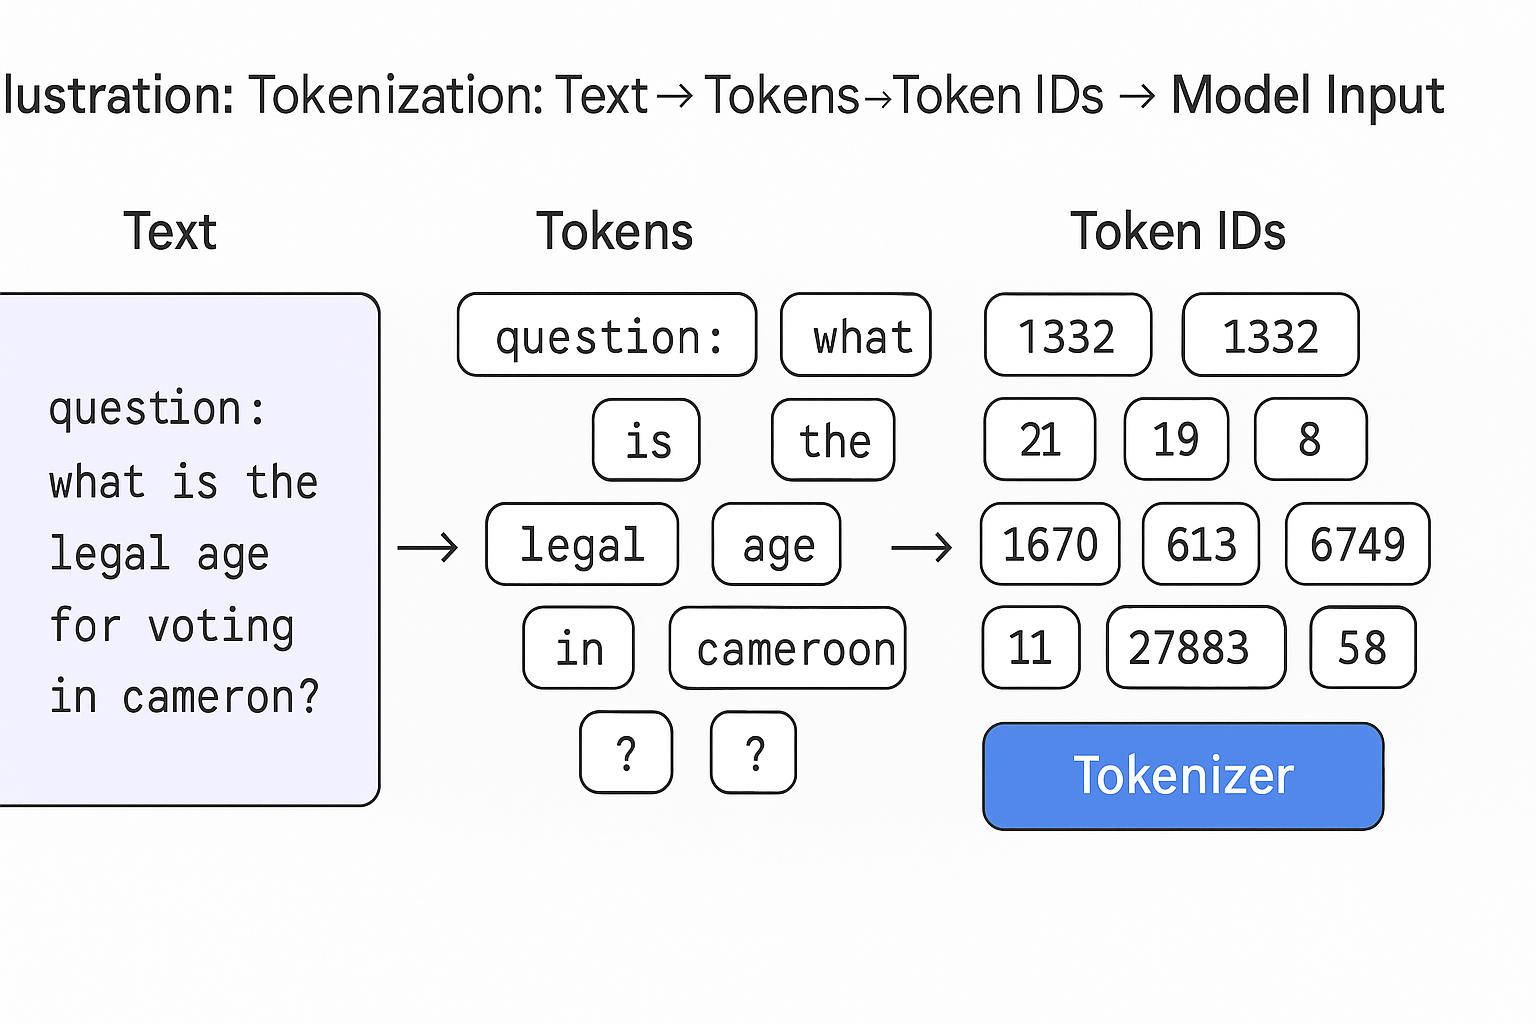





In [ ]:
# Load T5 tokenizer
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)

max_input_length = 128
max_target_length = 256

# Visualize tokenization on a sample
sample_input = train_inputs[0]
sample_target = train_targets[0]

print("🔡 Input tokens:", tokenizer.tokenize(sample_input))
print("🔢 Input token IDs:", tokenizer.encode(sample_input))
print("🔡 Target tokens:", tokenizer.tokenize(sample_target))
print("🔢 Target token IDs:", tokenizer.encode(sample_target))


## 🗂️ 10. Dataset Wrapping for PyTorch (With Explanations)

> **Why?**  
> Trainer expects PyTorch datasets—wrapping input/target tokens in a class speeds up batching.


In [ ]:
def tokenize(inputs, targets, max_input_length, max_target_length):
    # Returns tokenized (padded & truncated) tensors for both inputs & outputs
    tokenized_inputs = tokenizer(inputs, max_length=max_input_length, padding="max_length", truncation=True, return_tensors="pt")
    tokenized_targets = tokenizer(targets, max_length=max_target_length, padding="max_length", truncation=True, return_tensors="pt")
    return tokenized_inputs, tokenized_targets

class LegalChatbotDataset(Dataset):
    """Wraps input/target tensors as a PyTorch Dataset for training."""
    def __init__(self, inputs, targets):
        self.inputs, self.targets = tokenize(inputs, targets, max_input_length, max_target_length)
    def __len__(self):
        return self.inputs["input_ids"].shape[0]
    def __getitem__(self, idx):
        return {
            "input_ids": self.inputs["input_ids"][idx],
            "attention_mask": self.inputs["attention_mask"][idx],
            "labels": self.targets["input_ids"][idx]
        }

# Prepare the datasets
train_dataset = LegalChatbotDataset(train_inputs, train_targets)
val_dataset   = LegalChatbotDataset(val_inputs, val_targets)
test_dataset  = LegalChatbotDataset(test_inputs, test_targets)

print("✅ Datasets wrapped and ready for Trainer.")


## 🧠 11. Model Training

> **How does T5 learn?**  
> It minimizes the difference between predicted and gold-standard answers.  
> **Loss:** Cross-entropy on the output tokens.


In [ ]:
# Choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on:", device)

# Load model
# Load model
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

# Training arguments: explain every setting
training_args = TrainingArguments(
    output_dir=f"{project_dir}/t5_ckpt",
    num_train_epochs=4,               # Enough for a small dataset, raise for more data
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,                 # Gradually increase LR at the start
    weight_decay=0.01,                # Regularization
    logging_dir=f"{project_dir}/logs",
    logging_steps=10,
    evaluation_strategy="epoch",      # Evaluate at each epoch
    save_strategy="epoch",            # Save at each epoch
    load_best_model_at_end=True,      # Early stopping
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",                 # No remote logging in Colab
)

# Trainer wraps the full training loop
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)
print("🚀 Starting fine-tuning...")
trainer.train()


## 📈 12. BLEU Score Evaluation: *What is BLEU?*

> **BLEU** (*Bilingual Evaluation Understudy*) is a score (0–1) that tells us how close the model’s answer is to the human answer.

* **Formula:** BLEU = geometric mean of n-gram precision, penalized by brevity  
* **Visual Intuition:**  
  * 1.0 = Perfect copy  
  * 0.0 = Totally unrelated  
  * 0.3–0.6 is typical for generative Q&A with real-world data

![BLEU Formula](https://upload.wikimedia.org/wikipedia/commons/7/75/Bleu_Formula.svg)


In [ ]:
def calculate_bleu(references, predictions):
    """Returns BLEU score (corpus-level) for reference and predicted answers."""
    tokenized_refs = [[word_tokenize(ref)] for ref in references]
    tokenized_preds = [word_tokenize(pred) for pred in predictions]
    smoothie = SmoothingFunction().method1
    return corpus_bleu(tokenized_refs, tokenized_preds, smoothing_function=smoothie)

def evaluate_model(model, dataset, tokenizer, device):
    model.eval()
    preds, refs = [], []
    loader = DataLoader(dataset, batch_size=8)
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            outs = model.generate(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device),
                max_length=max_target_length,
                num_beams=4,
                early_stopping=True,
                no_repeat_ngram_size=2,
            )
            decoded_preds = tokenizer.batch_decode(outs, skip_special_tokens=True)
            decoded_refs  = tokenizer.batch_decode(batch["labels"], skip_special_tokens=True)
            preds.extend(decoded_preds)
            refs.extend(decoded_refs)
    bleu = calculate_bleu(refs, preds)
    return bleu, list(zip(preds, refs))

bleu_score, sample_preds = evaluate_model(model, test_dataset, tokenizer, device)
print(f"\n🌟 BLEU Score on Test Set: {bleu_score:.4f}\n")

for pred, ref in sample_preds[:3]:
    print("Q:", pred)
    print("A (ref):", ref, "\n")


## 💾 13. Save Model & Metadata


In [ ]:
save_dir = f"{project_dir}/legal_chatbot_model"
os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
with open(os.path.join(save_dir, "metadata.json"), "w") as f:
    json.dump({
        "model_name": model_name,
        "bleu": bleu_score,
        "max_input_length": max_input_length,
        "max_target_length": max_target_length,
        "trained_on": time.strftime("%Y-%m-%d %H:%M:%S"),
        "task": "Cameroon legal Q&A"
    }, f, indent=2)
print(f"✅ Model & metadata saved at: {save_dir}")


## 🧪 14. Test the Chatbot (Demo)


In [ ]:
def chatbot_response(question):
    """Take a raw question, preprocess, generate, and decode."""
    q = preprocess_text(question)
    input_text = "question: " + q
    input_ids = tokenizer(input_text, return_tensors="pt", max_length=max_input_length, padding="max_length", truncation=True).input_ids.to(device)
    with torch.no_grad():
        output = model.generate(
            input_ids=input_ids,
            max_length=max_target_length,
            num_beams=4,
            early_stopping=True,
            no_repeat_ngram_size=2,
        )
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Test on real questions
for q in [
    "Can I be arrested without a warrant in Cameroon?",
    "What rights do I have if police stop me?",
    "Is freedom of expression protected by law?"
]:
    print("❓", q)
    print("🤖", chatbot_response(q), "\n")


## 🚀 15. FastAPI Export & Docker Scaffold

**All code for API, Dockerfile, and requirements.txt gets written to Drive for production use.**


In [ ]:
api_code = '''
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch, re, nltk, os

app = FastAPI(title="Cameroon Legal Chatbot API")

class QueryRequest(BaseModel):
    question: str

# Load model/tokenizer
model_dir = "./legal_chatbot_model"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = T5Tokenizer.from_pretrained(model_dir)
model = T5ForConditionalGeneration.from_pretrained(model_dir).to(device)

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9.,;:?!\'"\\s]', '', text)
    text = re.sub(r'\\s+', ' ', text).strip()
    return text

@app.post("/chat")
async def chat(request: QueryRequest):
    input_text = "question: " + preprocess_text(request.question)
    input_ids = tokenizer(input_text, return_tensors="pt", max_length=128, padding="max_length", truncation=True).input_ids.to(device)
    output = model.generate(input_ids=input_ids, max_length=256, num_beams=4, early_stopping=True, no_repeat_ngram_size=2)
    answer = tokenizer.decode(output[0], skip_special_tokens=True)
    return {"answer": answer}
'''

with open(f"{project_dir}/app.py", "w") as f: f.write(api_code)

dockerfile = '''
FROM python:3.9-slim
WORKDIR /code
COPY ./requirements.txt /code/
RUN pip install --no-cache-dir -r requirements.txt
COPY . /code/
CMD ["uvicorn", "app:app", "--host", "0.0.0.0", "--port", "7860"]
'''
with open(f"{project_dir}/Dockerfile", "w") as f: f.write(dockerfile)

requirements = '''
fastapi==0.95.0
uvicorn==0.21.1
pydantic==1.10.7
transformers==4.28.1
torch==2.0.0
numpy==1.24.3
pandas==2.0.0
nltk==3.8.1
scikit-learn==1.2.2
'''
with open(f"{project_dir}/requirements.txt", "w") as f: f.write(requirements)


## 📦 16. Packaging for Download


In [ ]:
# Zip up everything for easy download/portability
!cd "/content/gdrive/MyDrive" && zip -r legal_chatbot_project.zip legal_chatbot
print("✅ Download ready at: /content/gdrive/MyDrive/legal_chatbot_project.zip")


# 🎉 **Project Complete!**
